In [1]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
from sklearn import preprocessing
import numpy as np
import time
import os
from PIL import Image
import json
from pathlib import Path
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime
import random
import matplotlib.pyplot as plt # plt 用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片

In [2]:
# Replace with valid values
ENDPOINT = "https://stylervision.cognitiveservices.azure.com/"
training_key = "d7fb9c199bdb4c76952c6cb56b862b47"
prediction_key = "afbc2a74d69247429481db68cb64be3d"
prediction_resource_id = "/subscriptions/14bf462c-fe1a-47c2-a915-5cacdd27e7b1/resourceGroups/styler/providers/Microsoft.CognitiveServices/accounts/stylervision-Prediction"

In [3]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

In [4]:
publish_iteration_name = "detectModel-test"

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print ("Creating project...")
project = trainer.create_project("Li Project", domain_id=obj_detection_domain.id)

Creating project...


In [5]:
# Make two tags in the new project
category_dict = { 1 :'short_sleeve_top', 2 :'long_sleeve_top', 3 :'short_sleeve_outwear', 4 :'long_sleeve_outwear', 
                  5 :'vest', 6 :'sling', 7 :'shorts', 8 :'trousers', 9 :'skirt', 10 :'short_sleeve_dress', 
                  11 :'long_sleeve_dress', 12 :'vest_dress', 13 :'sling_dress'}
regions_arr = [0] * 13
key_arr = [0] * 13
value_arr = [0] * 13
for i in range(1,14):
    category = category_dict.get(i)
    str_category = str(category)
    key_name = str_category + '_key'
    value_name = str_category + '_value'
    key_arr[i-1] = key_name
    value_arr[i-1] = value_name
    #tag_name = str_category + '_tag'
    #tag_name = trainer.create_tag(project.id, str_category)
    regions_name = str_category + '_regions'
    regions_arr[i-1] = regions_name
    #regions_name = {}
    
#這邊應該可以再優化
sling_dress_tag = trainer.create_tag(project.id, "sling dress") 
vest_dress_tag = trainer.create_tag(project.id, "vest dress")
short_sleeve_dress_tag = trainer.create_tag(project.id, "short sleeve dress")
sling_tag = trainer.create_tag(project.id, "sling")
vest_tag = trainer.create_tag(project.id, "vest")
long_sleeve_outwear_tag = trainer.create_tag(project.id, "long sleeve outwear")
short_sleeve_outwear_tag = trainer.create_tag(project.id, "short sleeve outwear")
long_sleeve_top_tag = trainer.create_tag(project.id, "long sleeve top")
long_sleeve_dress_tag = trainer.create_tag(project.id, "long sleeve dress")
short_sleeve_top_tag = trainer.create_tag(project.id, "short sleeve top")
skirt_tag = trainer.create_tag(project.id, "skirt")
shorts_tag = trainer.create_tag(project.id, "shorts")
trousers_tag = trainer.create_tag(project.id, "trousers")

In [6]:
#建一個資料夾 裡面放圖片跟json檔
base_location = 'C:/Users/JIALI/Desktop/project/VProject/train/image/'
#json_p = 'C:/Users/qingyu/Desktop/yutest/'
jList = os.listdir(base_location)

#這邊應該可以再優化
short_sleeve_top_regions = {}
long_sleeve_top_regions = {}
short_sleeve_outwear_regions = {}
long_sleeve_outwear_regions = {}
vest_regions = {}
sling_regions = {}
shorts_regions = {}
trousers_regions = {}
skirt_regions = {}
short_sleeve_dress_regions = {}
long_sleeve_dress_regions = {}
vest_dress_regions = {}
sling_dress_regions = {}

tag_num = 0

for file in jList:
    
    if file.endswith(".jpg"):
        img = Image.open( os.path.join(base_location,file))
        imgSize = img.size  #大小/尺寸
        pw = img.width       #图片的宽
        ph = img.height      #图片的高
        pf = img.format      #图像格式
     
        
# Region Left(rl) = X1 / Image Width
# Region Top(rt) = Y1 / Image Height
# Region Width(rw) = (X2 — X1) / image Width
# Region Height(rh)= (Y2 — Y1) / image Height
    
    if file.endswith(".json"):
        with open(os.path.join(base_location,file) , 'r') as reader:
            jf = json.loads(reader.read())
        strjf = str(jf)
        maxi = strjf.count('item') + 1
        for i in range (1,maxi):
            stri = str(i)
            category_id = jf['item'+stri]['category_id']
            category_name = category_dict.get(category_id)
            rl = jf['item'+stri]['bounding_box'][0]/pw
            rt = jf['item'+stri]['bounding_box'][1]/ph
            rw = (jf['item'+stri]['bounding_box'][2]-jf['item'+stri]['bounding_box'][0])/pw
            rh = (jf['item'+stri]['bounding_box'][3]-jf['item'+stri]['bounding_box'][1])/ph
            regions = category_name + '_regions'
            if regions in regions_arr:
                mydict = eval(regions)
                mydict[Path(file).stem]=[rl,rt,rw,rh,category_name]
                tag_num = tag_num + 1  
    if(tag_num>=4900):#因為在免費模式 要小於5000張
        break;

In [9]:
# Update this with the path to where you downloaded the images.
# Go through the data table above and create the images
print ("Adding images...")
total_count = 0
def upload():
    global total_count 
    count=0
    tagged_images_with_regions = []
    length = len(regions_arr)
    for i in range(0,length):
        key_arr[i] = list(eval(regions_arr[i]))
        value_arr[i] = list(eval(regions_arr[i]).values())
        for file_name in key_arr[i]:
            index = key_arr[i].index(file_name)
            x,y,w,h,c = value_arr[i][index]
            regions = c + '_regions'
            regions_dict = eval(regions)
            del regions_dict[file_name]
            key_arr[i] = list(regions_dict)
            value_arr[i] = list(regions_dict.values())
            tag = c + '_tag'
            regions = [ Region(tag_id=eval(tag).id, left=x,top=y,width=w,height=h) ] 
            count=count+1
            total_count = total_count+1
            with open(base_location  + file_name + ".jpg", mode="rb") as image_contents:
                tagged_images_with_regions.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), regions=regions))
           
            if(count>=64):
                print("count",count)
                print("total_count",total_count)
                break
        else:
            continue
        break
                
            
    upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=tagged_images_with_regions))

    tagged_images_with_regions.clear()

    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)
#end upload    

maxn = int(tag_num/64) + 1
for n in range (0,maxn): 
    upload()
    print(n)
#for n in range (0,maxn): upload()  


Adding images...
count 64
total_count 64
0
count 64
total_count 128
1
count 64
total_count 192
2
count 64
total_count 256
3
count 64
total_count 320
Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status: 

28
count 64
total_count 1920
29
count 64
total_count 1984
30
count 64
total_count 2048
31
count 64
total_count 2112
Image batch upload failed.
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image statu

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image stat

Image batch upload failed.
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image stat

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
I

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDu

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image stat

Image batch upload failed.
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image stat

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OKDuplicate
I

CustomVisionErrorException: No valid image files

In [10]:
print (total_count)#281-16 10分鐘   #4792-11
t1 = time.time()
print (time.asctime( time.localtime(t1) ))
print ("Training...")

iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(60)
t2 = time.time()
print (time.asctime( time.localtime(t2) ))
print ("花費時間",str(round((t2-t1)/60,2)),"分鐘")

4792
Wed Apr 21 21:38:14 2021
Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Wed Apr 21 21:56:21 2021
花費時間 18.11 分鐘


In [11]:
# The iteration is now trained. Publish it to the project endpoint
#trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)

trainer.publish_iteration(project.id, iteration.id,publish_iteration_name ,  prediction_resource_id)

print ("Done!")

Done!


002182.jpg


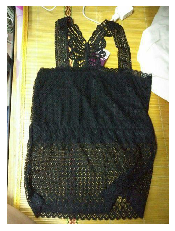

	skirt: 30.95% bbox.left = 0.06, bbox.top = 0.28, bbox.width = 0.93, bbox.height = 0.65
	short sleeve dress: 13.48% bbox.left = 0.06, bbox.top = 0.02, bbox.width = 0.94, bbox.height = 0.63
	short sleeve dress: 12.73% bbox.left = 0.06, bbox.top = 0.28, bbox.width = 0.93, bbox.height = 0.65
	long sleeve top: 7.42% bbox.left = 0.06, bbox.top = 0.28, bbox.width = 0.93, bbox.height = 0.65
	trousers: 4.35% bbox.left = 0.04, bbox.top = 0.34, bbox.width = 0.96, bbox.height = 0.63
	trousers: 4.13% bbox.left = 0.25, bbox.top = 0.00, bbox.width = 0.57, bbox.height = 0.29
	vest dress: 4.04% bbox.left = 0.06, bbox.top = 0.28, bbox.width = 0.93, bbox.height = 0.65
	trousers: 3.40% bbox.left = 0.28, bbox.top = 0.76, bbox.width = 0.24, bbox.height = 0.23
	long sleeve dress: 3.01% bbox.left = 0.06, bbox.top = 0.28, bbox.width = 0.93, bbox.height = 0.65
	short sleeve dress: 2.72% bbox.left = 0.27, bbox.top = 0.03, bbox.width = 0.54, bbox.height = 0.28
	short sleeve top: 2.06% bbox.left = 0.25, bbox.top 

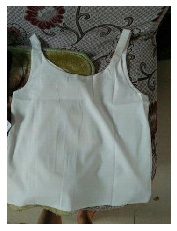

	vest dress: 25.47% bbox.left = 0.00, bbox.top = 0.31, bbox.width = 0.97, bbox.height = 0.59
	short sleeve top: 17.31% bbox.left = 0.00, bbox.top = 0.00, bbox.width = 1.00, bbox.height = 0.58
	vest: 13.86% bbox.left = 0.00, bbox.top = 0.31, bbox.width = 0.97, bbox.height = 0.59
	short sleeve top: 13.34% bbox.left = 0.00, bbox.top = 0.31, bbox.width = 0.97, bbox.height = 0.59
	vest: 4.96% bbox.left = 0.00, bbox.top = 0.03, bbox.width = 0.99, bbox.height = 0.60
	sling dress: 4.14% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.98, bbox.height = 0.62
	long sleeve top: 2.16% bbox.left = 0.00, bbox.top = 0.31, bbox.width = 0.97, bbox.height = 0.59
	shorts: 1.31% bbox.left = 0.07, bbox.top = 0.67, bbox.width = 0.78, bbox.height = 0.29
	short sleeve dress: 1.21% bbox.left = 0.00, bbox.top = 0.31, bbox.width = 0.97, bbox.height = 0.59
	long sleeve dress: 1.07% bbox.left = 0.00, bbox.top = 0.31, bbox.width = 0.97, bbox.height = 0.59
	long sleeve outwear: 1.06% bbox.left = 0.00, bbox.top = 0.

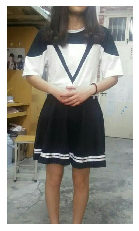

	short sleeve top: 58.34% bbox.left = 0.16, bbox.top = 0.09, bbox.width = 0.69, bbox.height = 0.48
	shorts: 53.81% bbox.left = 0.18, bbox.top = 0.40, bbox.width = 0.65, bbox.height = 0.33
	skirt: 41.52% bbox.left = 0.22, bbox.top = 0.39, bbox.width = 0.58, bbox.height = 0.36
	vest dress: 7.46% bbox.left = 0.15, bbox.top = 0.13, bbox.width = 0.71, bbox.height = 0.53
	vest: 6.12% bbox.left = 0.16, bbox.top = 0.09, bbox.width = 0.69, bbox.height = 0.48
	sling dress: 3.50% bbox.left = 0.16, bbox.top = 0.14, bbox.width = 0.67, bbox.height = 0.56
	trousers: 2.52% bbox.left = 0.24, bbox.top = 0.41, bbox.width = 0.54, bbox.height = 0.38
	short sleeve dress: 2.14% bbox.left = 0.15, bbox.top = 0.13, bbox.width = 0.71, bbox.height = 0.53
	long sleeve dress: 1.31% bbox.left = 0.15, bbox.top = 0.13, bbox.width = 0.71, bbox.height = 0.53
	short sleeve top: 1.26% bbox.left = 0.06, bbox.top = 0.22, bbox.width = 0.10, bbox.height = 0.06
	vest: 0.99% bbox.left = 0.06, bbox.top = 0.22, bbox.width = 0.10,

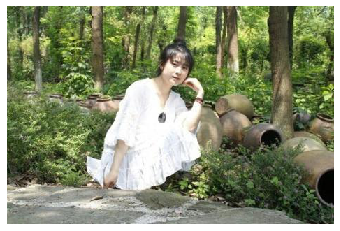

	short sleeve top: 69.00% bbox.left = 0.28, bbox.top = 0.28, bbox.width = 0.32, bbox.height = 0.54
	long sleeve top: 20.13% bbox.left = 0.30, bbox.top = 0.31, bbox.width = 0.31, bbox.height = 0.54
	long sleeve dress: 11.06% bbox.left = 0.29, bbox.top = 0.33, bbox.width = 0.30, bbox.height = 0.51
	short sleeve dress: 10.97% bbox.left = 0.29, bbox.top = 0.33, bbox.width = 0.30, bbox.height = 0.51
	vest dress: 5.05% bbox.left = 0.29, bbox.top = 0.33, bbox.width = 0.30, bbox.height = 0.51
	sling dress: 3.48% bbox.left = 0.29, bbox.top = 0.33, bbox.width = 0.30, bbox.height = 0.51
	skirt: 3.11% bbox.left = 0.25, bbox.top = 0.52, bbox.width = 0.37, bbox.height = 0.30
	trousers: 2.32% bbox.left = 0.25, bbox.top = 0.62, bbox.width = 0.16, bbox.height = 0.23
	skirt: 2.29% bbox.left = 0.32, bbox.top = 0.64, bbox.width = 0.22, bbox.height = 0.21
	vest: 1.95% bbox.left = 0.70, bbox.top = 0.49, bbox.width = 0.15, bbox.height = 0.22
	shorts: 1.50% bbox.left = 0.25, bbox.top = 0.62, bbox.width = 0.16

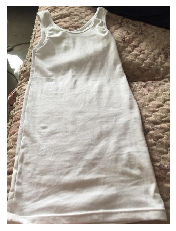

	short sleeve top: 36.30% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.63
	vest: 29.46% bbox.left = 0.00, bbox.top = 0.03, bbox.width = 0.93, bbox.height = 0.62
	vest dress: 29.42% bbox.left = 0.00, bbox.top = 0.03, bbox.width = 0.93, bbox.height = 0.62
	vest: 7.23% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.63
	short sleeve top: 4.16% bbox.left = 0.00, bbox.top = 0.03, bbox.width = 0.93, bbox.height = 0.62
	shorts: 2.99% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.63
	sling dress: 2.50% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.63
	long sleeve top: 2.29% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.63
	skirt: 2.06% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.63
	trousers: 1.65% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.height = 0.63
	vest dress: 1.55% bbox.left = 0.00, bbox.top = 0.35, bbox.width = 0.95, bbox.heig

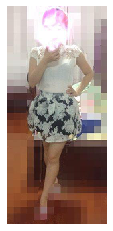

	skirt: 80.47% bbox.left = 0.18, bbox.top = 0.39, bbox.width = 0.58, bbox.height = 0.24
	short sleeve top: 71.25% bbox.left = 0.20, bbox.top = 0.17, bbox.width = 0.61, bbox.height = 0.22
	vest: 32.70% bbox.left = 0.20, bbox.top = 0.19, bbox.width = 0.61, bbox.height = 0.22
	sling dress: 23.90% bbox.left = 0.18, bbox.top = 0.17, bbox.width = 0.64, bbox.height = 0.46
	short sleeve top: 8.80% bbox.left = 0.30, bbox.top = 0.01, bbox.width = 0.34, bbox.height = 0.20
	trousers: 5.74% bbox.left = 0.31, bbox.top = 0.63, bbox.width = 0.34, bbox.height = 0.27
	long sleeve top: 3.43% bbox.left = 0.30, bbox.top = 0.01, bbox.width = 0.34, bbox.height = 0.20
	trousers: 2.54% bbox.left = 0.12, bbox.top = 0.40, bbox.width = 0.64, bbox.height = 0.23
	skirt: 2.24% bbox.left = 0.29, bbox.top = 0.54, bbox.width = 0.38, bbox.height = 0.13
	trousers: 1.98% bbox.left = 0.29, bbox.top = 0.54, bbox.width = 0.38, bbox.height = 0.13
	trousers: 1.98% bbox.left = 0.00, bbox.top = 0.59, bbox.width = 1.00, bbox.heig

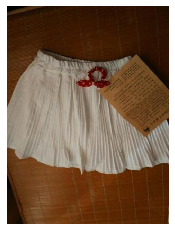

	skirt: 51.84% bbox.left = 0.00, bbox.top = 0.19, bbox.width = 0.93, bbox.height = 0.60
	short sleeve top: 11.33% bbox.left = 0.03, bbox.top = 0.18, bbox.width = 0.97, bbox.height = 0.56
	vest: 10.26% bbox.left = 0.00, bbox.top = 0.18, bbox.width = 0.93, bbox.height = 0.55
	long sleeve top: 7.94% bbox.left = 0.04, bbox.top = 0.19, bbox.width = 0.96, bbox.height = 0.60
	shorts: 2.74% bbox.left = 0.00, bbox.top = 0.18, bbox.width = 0.93, bbox.height = 0.55
	short sleeve dress: 2.60% bbox.left = 0.00, bbox.top = 0.19, bbox.width = 0.93, bbox.height = 0.60
	vest dress: 1.28% bbox.left = 0.00, bbox.top = 0.18, bbox.width = 0.86, bbox.height = 0.56
	long sleeve dress: 1.08% bbox.left = 0.04, bbox.top = 0.19, bbox.width = 0.96, bbox.height = 0.60
	skirt: 0.92% bbox.left = 0.12, bbox.top = 0.67, bbox.width = 0.85, bbox.height = 0.32
	short sleeve top: 0.90% bbox.left = 0.49, bbox.top = 0.24, bbox.width = 0.51, bbox.height = 0.31
	trousers: 0.80% bbox.left = 0.04, bbox.top = 0.19, bbox.width = 

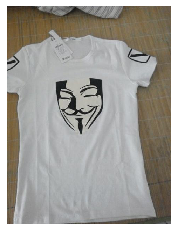

	short sleeve top: 63.18% bbox.left = 0.00, bbox.top = 0.12, bbox.width = 0.96, bbox.height = 0.55
	short sleeve top: 52.07% bbox.left = 0.00, bbox.top = 0.34, bbox.width = 0.97, bbox.height = 0.64
	vest: 18.16% bbox.left = 0.00, bbox.top = 0.34, bbox.width = 0.97, bbox.height = 0.64
	skirt: 3.82% bbox.left = 0.27, bbox.top = 0.92, bbox.width = 0.68, bbox.height = 0.08
	vest dress: 2.90% bbox.left = 0.00, bbox.top = 0.34, bbox.width = 0.97, bbox.height = 0.64
	long sleeve top: 2.77% bbox.left = 0.00, bbox.top = 0.34, bbox.width = 0.97, bbox.height = 0.64
	short sleeve top: 1.40% bbox.left = 0.32, bbox.top = 0.33, bbox.width = 0.28, bbox.height = 0.23
	trousers: 1.15% bbox.left = 0.27, bbox.top = 0.92, bbox.width = 0.68, bbox.height = 0.08
	shorts: 0.83% bbox.left = 0.27, bbox.top = 0.92, bbox.width = 0.68, bbox.height = 0.08
006448.jpg


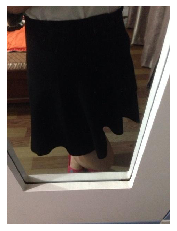

	trousers: 77.42% bbox.left = 0.10, bbox.top = 0.00, bbox.width = 0.71, bbox.height = 0.69
	skirt: 24.60% bbox.left = 0.04, bbox.top = 0.01, bbox.width = 0.82, bbox.height = 0.57
	long sleeve top: 13.44% bbox.left = 0.05, bbox.top = 0.00, bbox.width = 0.69, bbox.height = 0.10
	short sleeve top: 9.29% bbox.left = 0.05, bbox.top = 0.00, bbox.width = 0.69, bbox.height = 0.10
	trousers: 3.82% bbox.left = 0.38, bbox.top = 0.61, bbox.width = 0.29, bbox.height = 0.19
	shorts: 3.32% bbox.left = 0.10, bbox.top = 0.00, bbox.width = 0.72, bbox.height = 0.60
	short sleeve top: 2.26% bbox.left = 0.00, bbox.top = 0.02, bbox.width = 0.85, bbox.height = 0.65
	vest: 2.23% bbox.left = 0.05, bbox.top = 0.00, bbox.width = 0.69, bbox.height = 0.10
	vest: 1.80% bbox.left = 0.08, bbox.top = 0.00, bbox.width = 0.67, bbox.height = 0.67
	sling dress: 1.25% bbox.left = 0.05, bbox.top = 0.01, bbox.width = 0.82, bbox.height = 0.66
	vest dress: 1.24% bbox.left = 0.05, bbox.top = 0.01, bbox.width = 0.82, bbox.height

In [13]:
# Now there is a trained endpoint that can be used to make a prediction

# Open the sample image and get back the prediction results.
test_path ="C:/Users/JIALI/Desktop/project/VProject/validation/image/"
   
def quicktest():
    
    img = str(random.randint(0,9999)).zfill(6)+".jpg"
    lena = mpimg.imread(test_path+img)
    plt.imshow(lena)
    plt.axis('off') # 不顯示座標軸
    print(img)
    plt.show()
    with open(test_path+img, mode="rb") as test_data:
        results = predictor.detect_image(project.id, publish_iteration_name, test_data)
   
    
# Display the results.    
    for prediction in results.predictions:
        print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))

for i in range(1,10):
    quicktest()